In [1]:
from utils import *
import matplotlib.pyplot as plt

[0.        +0.j 0.70710678+0.j 0.        +0.j 0.70710678+0.j]
[0.        +0.j 0.70710678+0.j]


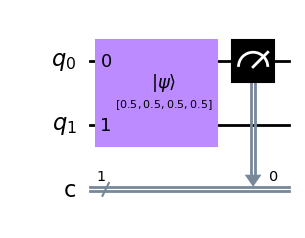

In [102]:
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)

qc = QuantumCircuit(2,1)
qc.initialize([1, 1, 1, 1]/np.sqrt(4), [0, 1])
# qc.h(0)
#qc.cx(0, 1)
#qc.hamiltonian(np.kron(sigma_x, sigma_x), np.pi, [0,1], label='Hami')
qc.measure(0, 0)

 
simulator = Aer.get_backend('statevector_simulator')
job = execute(qc, simulator, shots=1)
result = job.result()
statevector = result.get_statevector()
if '1' in result.get_counts().keys():
    statevector = np.asarray(statevector) 
    print(statevector)
    reduced_statevector = statevector[int(len(statevector)/2):]
    print(reduced_statevector)
else:
    print(0)

qc.draw(output='mpl')

In [140]:
# quantum modified gram-schmidt process
def quantum_modified_gram_schmidt(vectors, error_rate=1e-2):
    '''
    quantum modified gram-schmidt process
    vectors: input vectors, numpy array, vectors = [[v1], [v2], ..., [vn]]
    error_rate: error rate of the process
    '''
    vector_size = len(vectors[0])
    vector_number = len(vectors)
    qubit_number = int(np.ceil(np.log2(vector_size))) # qubit number for the 2nd register
    if 2 ** qubit_number < vector_size:
        qubit_number += 1
    total_qubit_number = qubit_number + 1 # qubit number for the quantum circuit
    max_runtime_of_circuit = int(np.log(1/error_rate) / error_rate)

    first_constructed_vector = vectors[0] / np.linalg.norm(vectors[0])
    first_constructed_vector_extended = np.concatenate((first_constructed_vector, np.zeros(2 ** qubit_number - vector_size)))
    # print(first_constructed_vector_extended)

    constructed_basis = [first_constructed_vector]

    current_hamiltonian = np.zeros((2**(total_qubit_number), 2**(total_qubit_number)), dtype=complex)
    current_hamiltonian += np.kron(np.outer(np.conjugate(first_constructed_vector_extended), first_constructed_vector_extended), np.array([[0, 0], [0, 1]], dtype=complex))
    # print(current_hamiltonian)
    # print(total_qubit_number)
    qubit_list = [i for i in range(total_qubit_number)]

    for i in range(1, vector_number):
        v = vectors[i] / np.linalg.norm(vectors[i]) # normalize input state
        v = np.concatenate((v, np.zeros(2 ** qubit_number - vector_size))) # input state as amplitude encoding
        count = 0
        qc = QuantumCircuit(total_qubit_number, 1)
        qc.initialize(v, range(1, total_qubit_number))
        qc.h(0)
        qc.hamiltonian(current_hamiltonian, np.pi, qubit_list, label='Hami')
        qc.h(0)
        qc.measure(0, 0)
        while count < max_runtime_of_circuit:
            simulator = Aer.get_backend('statevector_simulator')
            job = execute(qc, simulator, shots=1)
            result = job.result()
            if '0' in result.get_counts().keys():
                statevector = np.asarray(result.get_statevector()) 
                # print(statevector)
                current_hamiltonian += np.outer(np.conjugate(statevector), statevector)
                reduced_statevector = np.zeros(vector_size, dtype=complex)
                for j in range(vector_size):
                    reduced_statevector[j] = statevector[2 * j]
                constructed_basis.append(reduced_statevector)
                # print(count)
                break
            else:
                count += 1
    return qc, constructed_basis

In [141]:
vector_size = 6
vector_number = vector_size
vectors = []
for i in range(vector_number):
    np.random.seed(np.random.randint(0, 1000))
    tmp = np.random.rand(vector_size)
    vectors.append(tmp)
vectors = np.array(vectors)
print(vectors)
overlap_matrix = np.dot(vectors, vectors.T)
print(overlap_matrix)

[[0.92089465 0.47640436 0.3807715  0.36337574 0.16501301 0.92719924]
 [0.03536577 0.21796333 0.5276284  0.609546   0.64184371 0.81462537]
 [0.42428901 0.6319975  0.41750177 0.40256728 0.34409786 0.24056901]
 [0.15477466 0.29961915 0.78367472 0.82671529 0.20229288 0.91094538]
 [0.54340494 0.27836939 0.42451759 0.84477613 0.00471886 0.12156912]
 [0.87881444 0.27220706 0.76509005 0.33140447 0.79206176 0.42221378]]
[[2.23896464 1.4200395  1.27690382 1.76208911 1.21514791 1.87290176]
 [1.4200395  1.77427465 1.03525732 1.86010938 0.92087176 1.54842653]
 [1.27690382 1.03525732 1.09208693 1.20377562 0.95467509 1.37186284]
 [1.76208911 1.86010938 1.20377562 2.28207496 1.31028058 1.63597767]
 [1.21514791 0.92087176 0.95467509 1.31028058 1.28144166 1.21314877]
 [1.87290176 1.54842653 1.37186284 1.63597767 1.21314877 2.34722952]]


loss of orthogonality ||QQ^T-I||= 5.4265275846626546e-15


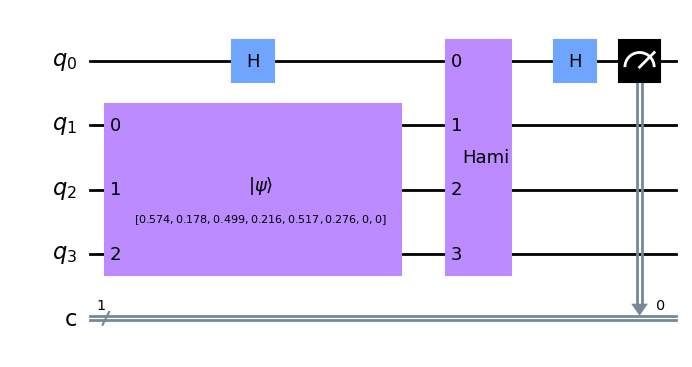

In [145]:
qc, orthogonal_basis = quantum_modified_gram_schmidt(vectors)
# print(orthogonal_basis)
orthogonal_basis = np.array(orthogonal_basis)
print(f'loss of orthogonality ||QQ^T-I||= {np.linalg.norm(np.dot(orthogonal_basis, orthogonal_basis.T) - np.eye(vector_number))}')
qc.draw(output='mpl')